#Model Architecture and Training

In [1]:
import os #For file Operations
from IPython.display import display
from PIL import ImageOps #Auto constract (For masked images)
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img #Load and Transform images
import numpy as np #For image processing operations
import random #To shuffle dataset
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Conv2D, Activation, SeparableConv2D, MaxPooling2D, add #Model Architecture
from tensorflow.keras.layers import BatchNormalization, Conv2DTranspose, UpSampling2D #Model Architecture
from tensorflow.keras import Input, Model, backend #Model Architecture
from tensorflow.keras.callbacks import ModelCheckpoint #Model Architecture
from google.colab import files #To download dataset

In [2]:
#We uploaded the dataset into github
adress = 'https://raw.githubusercontent.com/kynemre/CellSegmentation/master/DATA/Frames_and_Masks.zip';#Path to json files
!wget -q -O data.zip "{adress}";#Download dataset from github
!unzip -q data.zip
!rm data.zip ##Delete zip files after extract them

In [3]:
DIR_img = "images" #Name of image inputs 
DIR_mask = "masks" #Name of image outputs

In [4]:
input_img_paths = list() #Path for training images input
target_img_paths = list() #Path for training images input

for file_name in os.listdir(DIR_img): #Loop over images names
    input_img_paths.append(os.path.join(DIR_img, file_name)) #Path list created for images
input_img_paths.sort() #Sort images paths

for file_name in os.listdir(DIR_mask): #Loop over mask names
    target_img_paths.append(os.path.join(DIR_mask, file_name)) #Path list created for masks
target_img_paths.sort() #Sort masks paths

In [5]:
print("CHECK DATASET\n")

if len(input_img_paths) == len(target_img_paths): #Make sure numbers of inputs and outputs are equal
#Printing the inputs corresponding to the outputs
    for i in range(len(input_img_paths[:])):
        print("{} and {} correspondent".format(input_img_paths[i], target_img_paths[i]))
    print("lenght of dataset: \n{}.".format(len(input_img_paths)))
else:
    print("""Input and output lengths are not equal!!!
    Num of Input:{} 
    Num of Output:{}""".format(len(input_img_paths),len(target_img_paths)))

CHECK DATASET

images/frame1.jpg and masks/frame1.png correspondent
images/frame13.jpg and masks/frame13.png correspondent
images/frame15.jpg and masks/frame15.png correspondent
images/frame153.jpg and masks/frame153.png correspondent
images/frame213.jpg and masks/frame213.png correspondent
images/frame217.jpg and masks/frame217.png correspondent
images/frame28.jpg and masks/frame28.png correspondent
images/frame3.jpg and masks/frame3.png correspondent
images/frame312.jpg and masks/frame312.png correspondent
images/frame34.jpg and masks/frame34.png correspondent
images/frame358.jpg and masks/frame358.png correspondent
images/frame493.jpg and masks/frame493.png correspondent
images/frame579.jpg and masks/frame579.png correspondent
images/frame75.jpg and masks/frame75.png correspondent
images/frame8.jpg and masks/frame8.png correspondent
lenght of dataset: 
15.


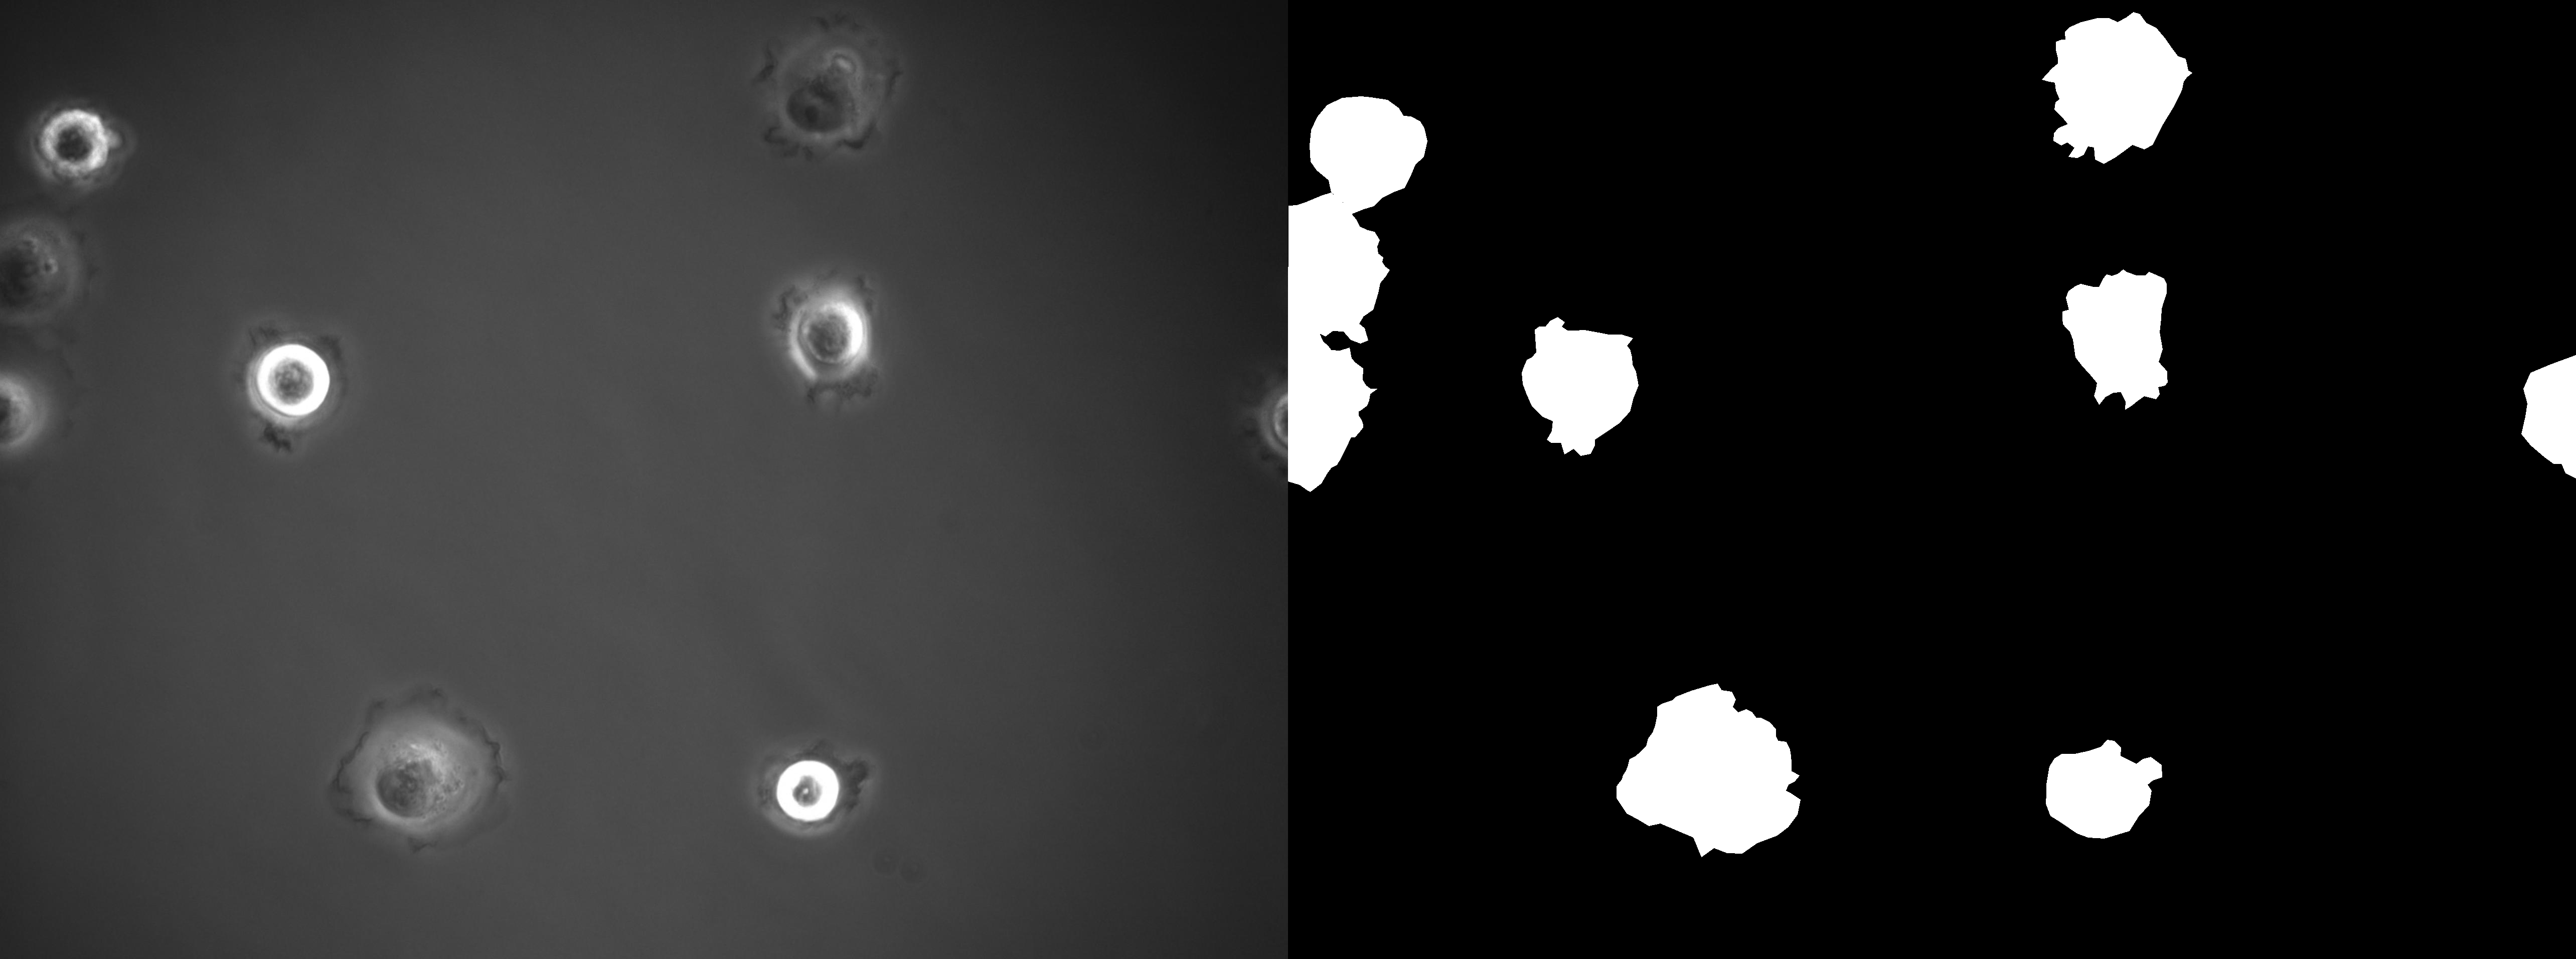

In [6]:
orginal_frame = load_img(path=input_img_paths[1]) #Load original image
orginal_frame = img_to_array(img=orginal_frame) #Convert to numpy array

#Load masked image
mask_frame = ImageOps.autocontrast(load_img(target_img_paths[1])) #Normalize pixel values between 0 to 255
mask_frame = img_to_array(img=mask_frame)#Convert to numpy array
#We converted images to numpy dataframe in order to combine them
display(array_to_img(np.concatenate([orginal_frame,mask_frame],axis=1))) #We combine images vertically and display

In [7]:
img_size = (512, 512) #Set size of training images
num_classes = 4
batch_size = 2

In [8]:
class Data(Sequence):
    #
    #We linked sending the dataset to a sequence
    #We used this method because it is safer and more straightforward than building a generator

    #The __getitem__ function retrieves a batch of input and target images based on the given index and returns them as arrays.
    #Alternatively a generator can be used
    #

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):

        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
        return x, y

In [9]:
##################
#
#Model architecture
#
#################

def get_model(img_size, num_classes):
    inputs = Input(shape=img_size + (3,))

    x = Conv2D(16, (3,3), strides=2, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    previous_block_activation = x


    lyrs = [32, 64, 128, 256]

    for filters in lyrs[1:]:
        x = Activation("relu")(x)
        x = SeparableConv2D(filters=filters, kernel_size=(3,3), padding="same")(x)
        x = BatchNormalization()(x)

        x = Activation("relu")(x)
        x = SeparableConv2D(filters=filters, kernel_size=(3,3), padding="same")(x)
        x = BatchNormalization()(x)

        x = MaxPooling2D(pool_size=(2,2), strides=2, padding="valid")(x)

        residual = Conv2D(filters=filters, kernel_size=(1,1), strides=2, padding="same")(
            previous_block_activation
        )
        x = add([x, residual])  
        previous_block_activation = x 



    previous_block_activation = x

    for filters in lyrs[::-1]:
        x = Activation("relu")(x)
        x = Conv2DTranspose(filters=filters, kernel_size=(3,3), padding="same")(x)
        x = BatchNormalization()(x)

        x = Activation("relu")(x)
        x = Conv2DTranspose(filters=filters, kernel_size=(3,3), padding="same")(x)
        x = BatchNormalization()(x)

        x = UpSampling2D(size=2)(x)


        residual = UpSampling2D(size=2)(previous_block_activation)
        residual = Conv2D(filters, 1, padding="same")(residual)
        x = add([x, residual])
        previous_block_activation = x

    outputs = Conv2D(filters=num_classes, kernel_size=(1,1), activation="sigmoid", padding="same")(x) #softmax 

    model = Model(inputs, outputs)
    return model


backend.clear_session()

model = get_model(img_size, num_classes)

In [10]:
ts = 13 #Num of data we will use in the training

#We shuffled the list of data paths
#We provide the same seed so that the input and output parity is not distorted
random.Random(67).shuffle(input_img_paths) 
random.Random(67).shuffle(target_img_paths)

train_input_img_paths = list()
train_target_img_paths = list()
val_input_img_paths = list()
val_target_img_paths = list()

for i in range(len(input_img_paths)):
    if 'e15.' in input_img_paths[i] or 'e217.' in input_img_paths[i]:
        val_input_img_paths.append(input_img_paths[i])
        val_target_img_paths.append(target_img_paths[i])
    else:
        train_input_img_paths.append(input_img_paths[i])
        train_target_img_paths.append(target_img_paths[i])
#Data object creation for training
train_gen = Data(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
#Data object creation for validation
val_gen = Data(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_input_img_paths

['images/frame217.jpg', 'images/frame15.jpg']

In [11]:
#Model training
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

mc = ModelCheckpoint("best_model.h5", save_best_only=True)

epochs = 250
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=[mc]);

Epoch 1/250
6/6 [==============================] - 30s 482ms/step - loss: 4.0226 - val_loss: 44.9754
Epoch 2/250
6/6 [==============================] - 2s 329ms/step - loss: 0.5062 - val_loss: 1.8470
Epoch 3/250
6/6 [==============================] - 2s 292ms/step - loss: 0.3920 - val_loss: 2.1662
Epoch 4/250
6/6 [==============================] - 2s 373ms/step - loss: 0.2137 - val_loss: 4.7275
Epoch 5/250
6/6 [==============================] - 2s 376ms/step - loss: 0.4986 - val_loss: 1.7796
Epoch 6/250
6/6 [==============================] - 2s 331ms/step - loss: 0.3114 - val_loss: 0.6377
Epoch 7/250
6/6 [==============================] - 2s 291ms/step - loss: 0.3719 - val_loss: 0.8678
Epoch 8/250
6/6 [==============================] - 2s 287ms/step - loss: 0.2877 - val_loss: 0.9543
Epoch 9/250
6/6 [==============================] - 2s 325ms/step - loss: 0.2144 - val_loss: 0.5263
Epoch 10/250
6/6 [==============================] - 3s 443ms/step - loss: 0.2808 - val_loss: 0.3866
Epoch 1

1/1 [==============================] - 1s 809ms/step


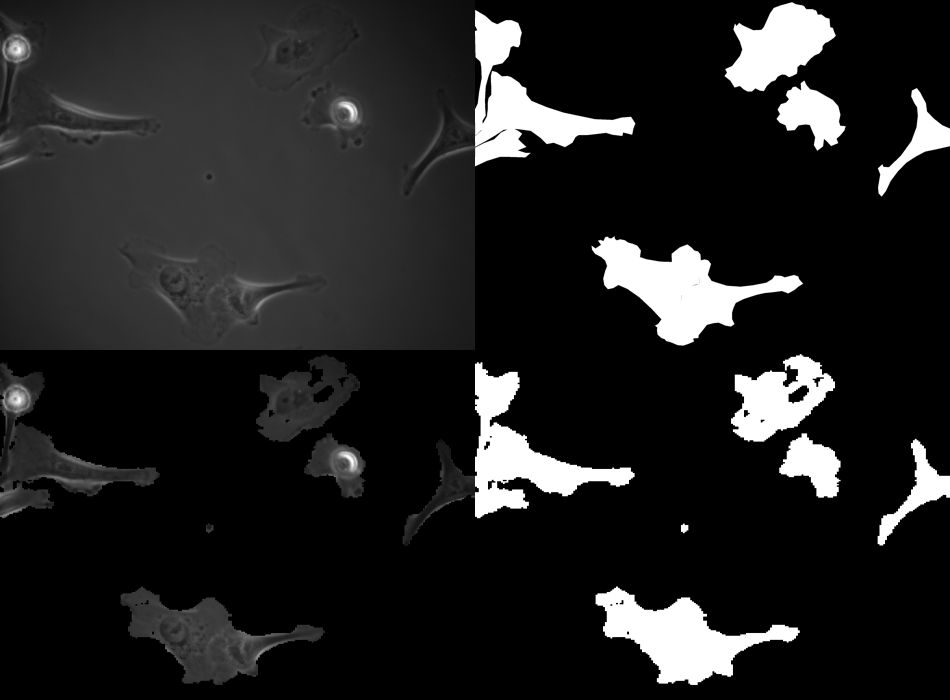

In [12]:
test_img_paths = val_input_img_paths[:2] #input
test_mask_paths = val_target_img_paths[:2] #output

#For take prediction externally
#test_img_paths = ["/content/images/frame1.jpg","/content/images/frame153.jpg"] #input
#test_mask_paths = ["/content/images/frame1.jpg","/content/images/frame153.jpg"] #output - if not exists, could be given same path as input

display_size = (475,350) #display size
i = 0 #Which element on list(test_img_paths)


try_batch_size = len(test_img_paths) #We changed batch size to prevent errors
#You faced with and error if batch size is longer than list
 
if try_batch_size > 0:
    val_gen = Data(try_batch_size, img_size, test_img_paths, test_mask_paths)
    val_preds = model.predict(val_gen)

    img = load_img(path=test_img_paths[i]) #load original image
    img = img_to_array(img.resize(display_size)) 


    gt = ImageOps.autocontrast(load_img(test_mask_paths[i]))
    gt = img_to_array(gt.resize(display_size))


    mask_ = np.argmax(val_preds[i], axis=-1)
    mask_ = np.expand_dims(mask_, axis=-1)
    mask_ = ImageOps.autocontrast(array_to_img(mask_))
    mask_ = img_to_array(mask_.resize(display_size))
    mask = np.zeros(display_size[::-1]+(3,))
    mask[:,:,0] = mask_[:,:,-1]
    mask[:,:,1] = mask_[:,:,-1]
    mask[:,:,2] = mask_[:,:,-1]

    dp1 = array_to_img(np.concatenate([img,gt], axis=1))
    dp2 = array_to_img(np.concatenate([img*(mask/255.),mask], axis=1))
    display(array_to_img(np.concatenate([dp1, dp2], axis=0)))

else:
    print(
"""
There is an error.
Can you check the content in "test_img_paths"?
"""
    )

In [13]:
model_save_name = "model28ve213.h5" #Name of the model
model.save(model_save_name) #Save model
files.download("/content/"+model_save_name) #Download model


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:
from copy import copy     
eski_model = copy(model)  #Copy the model to avoid conflicts

#Examination of the model

In [15]:
from tensorflow.keras.models import load_model 
import matplotlib.pyplot as plt 
from natsort import natsorted  

In [16]:
model = load_model('/content/model28ve213.h5') #Load new model
#model.summary()

In [17]:
def prediction_func(test_img_paths, test_mask_paths, img_size):#Precition function

#
#Inputs: Image path, output path and image size
#Returns: A list of masked images
#

    outputs = list()
    for i in range(len(test_mask_paths)):
        
        val_gen = Data(batch_size=1, 
                       img_size=img_size, 
                       input_img_paths=[test_img_paths[i]], 
                       target_img_paths=[test_mask_paths[i]])
        val_preds = model.predict(val_gen)
        
        mask_ = np.argmax(val_preds[0], axis=-1)
        mask_ = np.expand_dims(mask_, axis=-1)
        mask = np.zeros(img_size[::-1]+(3,))
        mask[:,:,0] = mask_[:,:,-1]
        mask[:,:,1] = mask_[:,:,-1]
        mask[:,:,2] = mask_[:,:,-1]
        outputs.append(mask.astype(np.uint8))
    return outputs

In [18]:
input_img_paths = natsorted(input_img_paths) #Sort paths
target_img_paths = natsorted(target_img_paths) #Sort paths
outputs = prediction_func(input_img_paths,target_img_paths,img_size) #Prediction results

1/1 [==============================] - 0s 133ms/step


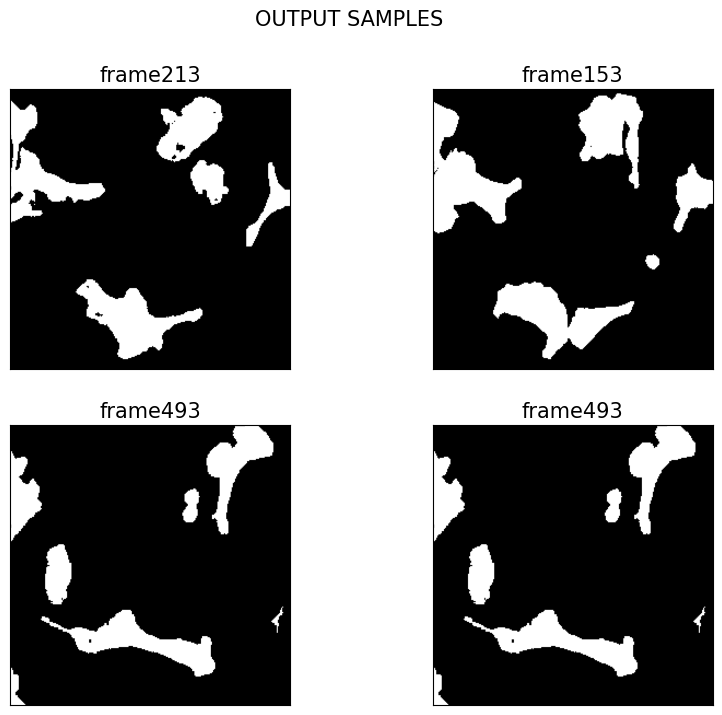

In [19]:
fig, axs = plt.subplots(2,2,figsize=(10,8)) #Create frames
fig.suptitle("OUTPUT SAMPLES",fontsize=15) #We give titles to frames
for i in range(2):
    for j in range(2):
        c = random.randint(1,len(outputs)-1)
        axs[i,j].imshow(outputs[c]*255);#Draw outputs
        axs[i,j].set_title(input_img_paths[c][7:-4],fontsize=15)#We give titles to images
        plt.setp(axs[i,j].get_xticklabels(), visible=False) #Axis deletion
        plt.setp(axs[i,j].get_yticklabels(), visible=False) #Axis deletion
        axs[i,j].tick_params(axis='both', which='both', length=0) #Axis deletion

In [20]:
scores = list() #A list to store prediction scores

for i, path in enumerate(target_img_paths): #Loop over images
    img = load_img(path=path) #Load original images
    img = img_to_array(img.resize(img_size)) #Convert image to numpy array

    predict = outputs[i]

    dice = np.sum(predict[img==1])*2.0 / (np.sum(predict) + np.sum(img))#We calculated dice score of image
    scores.append((path[6:-4],dice)) #Append score and name of the image to our scores list
scores = np.array(scores) #We convert scores list to numpy array

print("Max Dice Score: {}\nMin Dice Score: {}".format(round(float(max(scores[:,1])),3), round(float(min(scores[:,1])),3)))

Max Dice Score: 0.981
Min Dice Score: 0.894


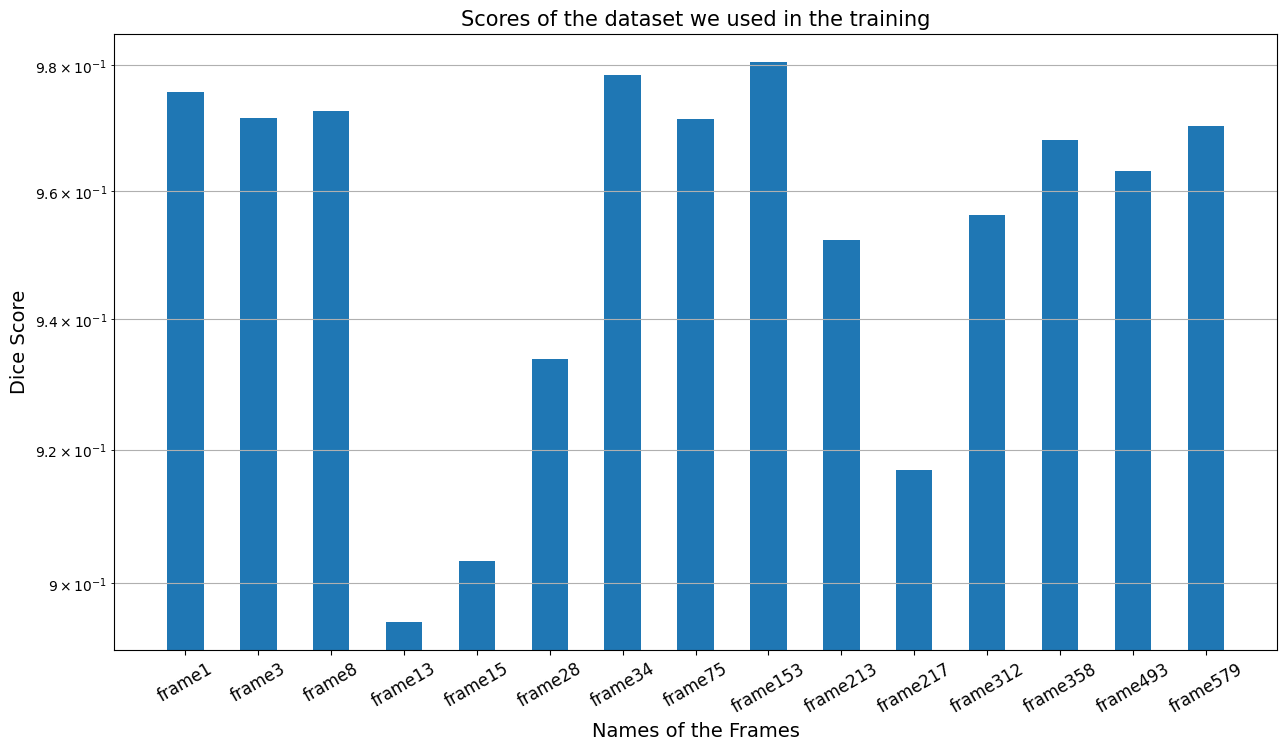

In [22]:
#
#Visualization of the scores
#

y=scores[:,1].astype(np.float32)
plt.figure(figsize=(15,8))
plt.bar(x=scores[:,0],
        height=y,
        width=0.5,
        log=True)
plt.xticks(rotation=30, fontsize=12)
plt.title("Scores of the dataset we used in the training", fontsize=15)
plt.xlabel("Names of the Frames", fontsize=14)
plt.ylabel("Dice Score", fontsize=14)
plt.grid(True, which="both", axis='y')
plt.savefig('graph.png',dpi=600)

In [23]:
scores

array([['frame1', '0.9757996276865798'],
       ['frame3', '0.9715567723781277'],
       ['frame8', '0.972722283205269'],
       ['frame13', '0.8943870373065541'],
       ['frame15', '0.903278097982709'],
       ['frame28', '0.9338949786989613'],
       ['frame34', '0.9784813837584286'],
       ['frame75', '0.9714743106388408'],
       ['frame153', '0.98063810085024'],
       ['frame213', '0.9522953589531581'],
       ['frame217', '0.9169572145741227'],
       ['frame312', '0.9561380899677062'],
       ['frame358', '0.9680383770662351'],
       ['frame493', '0.963199905223096'],
       ['frame579', '0.9703354588300527']], dtype='<U32')

#Labeling cells from videos and images using the model

In [24]:
import cv2
from google.colab import files #To download files

In [25]:
def spiltVideoinFrame(videoPath, savePath = '', imgName='frame'):#A function to separate the videos into frames
    cap = cv2.VideoCapture(videoPath)#Assign video to a variable
    success, image = cap.read()#Load the first frame
    count = 0 #A counter to count number of frames in the video
    print('Reading...')
    while success:#Stay in loop while there are frames
        savePath_copy = savePath[:]#We copied the path to not change the original path
        savePath_copy = os.path.join(savePath, imgName+str(count)+'.jpg')#We created the path that user asked
        cv2.imwrite(savePath_copy, image) # Saved the frame
        success,image = cap.read()#Load the next frame
        count += 1
    print('{} frames read: '.format(count))#Print the number of frames

In [26]:
adress = 'https://ndownloader.figshare.com/files/16407260';#Video path
!rm video.avi;#Delete if video exists
!wget -q -O video.avi "{adress}";#Download video

rm: cannot remove 'video.avi': No such file or directory


In [27]:
DIRname = "frames"
!mkdir "{DIRname}"

path = r'/content/video.avi'
#   == >    Do not forget create the directory for savePath       <== 
spiltVideoinFrame(videoPath = path, savePath = DIRname, imgName='frame')

Reading...
600 frames read: 


In [28]:
estimative_img_paths = list()

for file_name in os.listdir(DIRname): #Counting our training inputs
    estimative_img_paths.append(os.path.join(DIRname, file_name)) #the path of training inputs

estimative_img_paths = natsorted(estimative_img_paths)

estimative_mask_paths = estimative_img_paths[:]

In [29]:
outputs = list()
batch_size_for_predict = 1
for i in range(len(estimative_mask_paths)):
    
    val_gen = Data(batch_size_for_predict, 
                   img_size, 
                   [estimative_img_paths[i]],
                   [estimative_mask_paths[i]])
    val_preds = model.predict(val_gen)
    
    mask = np.argmax(val_preds[0], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    outputs.append(mask)
print("Num of predictions:", len(outputs))

1/1 [==============================] - 0s 129ms/step
Num of predictions: 600


In [30]:
out = cv2.VideoWriter('output.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 20, (512, 512))

for output in  outputs:
    out.write(cv2.cvtColor(output.astype(np.uint8)*255, 
                           cv2.COLOR_GRAY2BGR))
    
out.release()

In [31]:
files.download("/content/output.avi") #Download output video

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [32]:
out_con = cv2.VideoWriter('output_con.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 20, (1024, 512))

for i,output in  enumerate(outputs):
    frame_org = cv2.imread(estimative_img_paths[i])
    frame_org = cv2.resize(frame_org, img_size)
    frame_predict = cv2.cvtColor(output.astype(np.uint8)*255,cv2.COLOR_GRAY2BGR)
    
    out_con.write(np.concatenate([frame_org,frame_predict],axis=1))
    
out_con.release()

In [33]:
files.download("/content/output_con.avi") #Download output video

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>